In [1]:
import os
import sys
import json
import time
import pickle
import gspread
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy import integrate, signal, stats, fftpack

## The following is needed to export text correctly for Illustrator ##
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)

In [4]:
%matplotlib notebook

Load Zap_Zip-log_exp to get metadata for experiments

In [5]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [6]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
}

In [7]:
area_colors = {
    'MO': (31/255, 157/255, 90/255), # [31, 157, 90] 'blue'
    'ACA': (64/255, 166/255, 102/255), # [64, 166, 102] 'deepskyblue'
    'SS': (24/255, 128/255, 100/255), # [24, 128, 100] 'blueviolet'
    'VIS': (8/255, 133/255, 140/255), # [8, 133, 140] 'green'
    'MO-TH': (255/255, 112/255, 128/255), # [255, 112, 128] 'steelblue'
#     'VIS-TH': 'olivedrab'
}

In [8]:
# state_colors = {
#     'awake': (120/255, 156/255, 74/255),
#     'anesthetized': (130/255, 122/255, 163/255),
#     'recovery': (93/255, 167/255, 229/255)
# }
state_colors = {
    'resting': 'royalblue',
    'running': 'seagreen',
    'anesthetized': 'indianred',
}

#### Functions

In [9]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='resting'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

In [10]:
def get_stim_event_times(stim_table, stim_type, stim_param, sweep, trials='resting'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].onset.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].onset.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].onset.values

In [11]:
def p_stars(test_pval):
    if test_pval < 0.001:
        return '***'
    elif test_pval < 0.01:
        return '**'
    elif test_pval < 0.05:
        return '*'
    else:
        return 'n.s.'

## Load subjects from file

In [12]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_CSD_subjects.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [13]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        mdata['exp'] = EEGexp(mdata['data_loc'], preprocess=False, make_stim_csv=False)
    print('')

MOs_superficial

 575102
Experiment type: electrical and sensory stimulation
 571619
Experiment type: electrical stimulation

MOs_deep

 546655
Experiment type: electrical and sensory stimulation
 551399
Experiment type: electrical stimulation
 551397
Experiment type: electrical and sensory stimulation
 569062
Experiment type: electrical and sensory stimulation
 569068
Experiment type: electrical and sensory stimulation
 569069
Experiment type: electrical and sensory stimulation
 569064
Experiment type: electrical and sensory stimulation
 569073
Experiment type: electrical and sensory stimulation
 571619
Experiment type: electrical stimulation

SSp_superficial

 571620
Experiment type: electrical and sensory stimulation
 586466
Experiment type: electrical and sensory stimulation
 586468
Experiment type: electrical and sensory stimulation
 590479
Experiment type: electrical stimulation
 590480
Experiment type: electrical and sensory stimulation
 599017
Experiment type: electrical and se

In [14]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs'

## All subjects

In [15]:
## Parameters ##
ctx_regions = ['MO', 'ACA', 'SS', 'VIS']
time_bin = 0.0025 # size of time bins (s)

current_levels = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']

sig_test_window = [0.0, 0.3]
sigalpha = 0.05

burst_window = [0.075, 0.3]

early_window = [0.002, 0.025]
late_window = [0.075, 0.3]

example_mice = {
    'MOs_superficial': '571619',
    'MOs_deep': '571619',
}

In [16]:
example_unit_info = {}
example_unit_spikes = {}
example_pop_sdf = {}
all_subs_stats = []
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    stim_area = group[:2]
    stim_depth = group.split('_')[-1]
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')
        
        ## Load unit info ##
        fn_units_info = os.path.join(evoked_data_folder, 'all_units_info.csv')
        if os.path.exists(fn_units_info):
            unit_info = pd.read_csv(fn_units_info)
            with open(os.path.join(evoked_data_folder, 'units_event_spikes.pkl'), 'rb') as unit_file:
                all_unit_event_spikes = pickle.load(unit_file)
        else:
            print('  {} not found. Not analyzing this subject.'.format(fn_units_stats))
            continue

        ## Grab exp metadata from Zap_Zip-log_exp ##
        exp_meta = zzmetadata[(
            (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
            (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
        )].squeeze()
        currentstr = exp_meta['Current (uA)'].replace(' ','')
        currents_list = []
        for char in currentstr.split('/'):
            if char.isdecimal():
                currents_list.append(char)

        ## Load stim log (includes running speed now) ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})
        event_window = all_unit_event_spikes['event_window']
        bins = np.arange(event_window[0], event_window[1] + time_bin, time_bin)
        timex = bins[:-1] + time_bin/2
        
        ## Loop through regions to get units: RS only for CTX, all units for MO-TH ##
        reg_unit_info = {}
        for region in [stim_area, 'MO-TH']:
            if region in ctx_regions:
                regdf = unit_info[(unit_info['cell_type'] == 'RS') & (unit_info['parent'] == region)]
            else:
                regdf = unit_info[unit_info['parent'] == region]
            print('  {} has {:d} units'.format(region, len(regdf)))
            if len(regdf) > 4:
                reg_unit_info[region] = regdf.sort_values(by='depth').reset_index(drop=True)
        if len(reg_unit_info) == 2:
            sub_has_both_regs = True
        else:
            sub_has_both_regs = False

        ## Get event inds ##
        all_event_inds = {}
        for leveli, parami in zip(current_levels, currents_list):
            all_event_inds[leveli] = {}
            for statei in ['awake', 'anesthetized']:
                sweeps = mdata['states'][statei]
                if not sweeps:
                    continue
                state_events = []
                for sweepi in sweeps:
                    events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials='all')
                    if len(events) == 0:
                        continue
                    state_events.append(events)
                all_event_inds[leveli][statei] = np.concatenate(state_events)
#                 if statei == 'awake':
#                     substates = ['stationary', 'moving']
#                     for substatei in substates:
#                         state_events = []
#                         for sweepi in sweeps:
#                             events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=substatei)
#                             if len(events) == 0:
#                                 continue
#                             state_events.append(events)
#                         all_event_inds[leveli][substatei] = np.concatenate(state_events)
        
        if (group in example_mice.keys()) and (mouse_num == example_mice[group]):
            example_unit_info[group] = reg_unit_info
            example_unit_spikes[group] = {}
            example_pop_sdf[group] = {}
        
        ## Get evoked spikes ##
        start = time.time()
        for leveli, states_event_times in all_event_inds.items():
            if (group in example_mice.keys()) and (mouse_num == example_mice[group]):
                example_unit_spikes[group][leveli] = {}
                example_pop_sdf[group][leveli] = {}
            for statei in test_states:
                event_inds = states_event_times[statei]
                if (group in example_mice.keys()) and (mouse_num == example_mice[group]):
                    example_unit_spikes[group][leveli][statei] = {}
                    example_pop_sdf[group][leveli][statei] = {}
                for regi, regdf in reg_unit_info.items():
                    stim_ctx = regi == stim_area
                    if (group in example_mice.keys()) and (mouse_num == example_mice[group]):
                        unit_firing_rates = np.zeros((len(regdf), len(timex)), dtype=float) * np.nan
                    
                    sig_evoked_units = np.zeros(len(regdf), dtype=int)
                    burst_trials = np.zeros(len(regdf), dtype=float)
                    early_spike_latency = np.zeros(len(regdf), dtype=float)
                    late_spike_latency = np.zeros(len(regdf), dtype=float)
                    ## Get unit event spike times ##
                    for ii, unitrow in regdf.iterrows():
                        unit_event_spikes = [
                            all_unit_event_spikes['event_spikes'][unitrow.unit_id][ei] for ei in event_inds]
                        unit_event_bursts = [
                            all_unit_event_spikes['event_bursts'][unitrow.unit_id]['times'][ei] for ei in event_inds]
                        
                        if (group in example_mice.keys()) and (mouse_num == example_mice[group]):
                            example_unit_spikes[group][leveli][statei][unitrow.unit_id] = {
                                'spikes': unit_event_spikes, 'bursts': unit_event_bursts
                            }
                            ## Get firing rate for pop SDF ##    
                            unit_event_counts, edges = np.histogram(np.concatenate(unit_event_spikes), bins)
                            unit_firing_rates[ii, :] = unit_event_counts / (time_bin * len(event_inds))
                        
                        prespikes = np.zeros(len(event_inds), dtype=int)
                        postspikes = np.zeros(len(event_inds), dtype=int)
                        trial_counts = np.zeros(len(event_inds), dtype=int)
                        earlyfirstspikes = []
                        latefirstspikes = []
                        for jj, uspikesi in enumerate(unit_event_spikes):
                            ## Count spikes ##
                            prespikes[jj] = np.sum((uspikesi >= -sig_test_window[1]) & (uspikesi <= -sig_test_window[0]))
                            postspikes[jj] = np.sum((uspikesi >= sig_test_window[0]) & (uspikesi <= sig_test_window[1]))
                            
                            ## Count bursts ##
                            windowbursts = np.nonzero(
                                (unit_event_bursts[jj] >= burst_window[0]) & (unit_event_bursts[jj] <= burst_window[1]))[0]
                            if len(windowbursts) > 0:
                                trial_counts[jj] = 1
                                
                            ## Find first spikes ##
                            earlyspikes = np.nonzero((uspikesi >= early_window[0]) & (uspikesi <= early_window[1]))[0]
                            if len(earlyspikes) > 0:
                                earlyfirstspikes.append(uspikesi[earlyspikes[0]])
                            latespikes = np.nonzero((uspikesi >= late_window[0]) & (uspikesi <= late_window[1]))[0]
                            if len(latespikes) > 0:
                                latefirstspikes.append(uspikesi[latespikes[0]])
                        
                        wstat, pval = stats.wilcoxon(x=postspikes, y=prespikes, zero_method='zsplit')
                        sig_evoked_units[ii] = pval < sigalpha
                        burst_trials[ii] = np.mean(trial_counts)
                        early_spike_latency[ii] = np.median(earlyfirstspikes)
                        late_spike_latency[ii] = np.median(latefirstspikes)
                        
                    all_subs_stats.append([
                        group, mouse_num, stim_area, stim_depth, sub_has_both_regs, regi, stim_ctx, len(regdf), leveli, statei,
                        np.mean(sig_evoked_units), np.mean(burst_trials), np.nanmedian(early_spike_latency),
                        np.nanmedian(late_spike_latency)
                    ])
                    ## 03/28/22 changed burst probability to mean across all units (instead of median)
                    if (group in example_mice.keys()) and (mouse_num == example_mice[group]):
                        example_pop_sdf[group][leveli][statei][regi] = [timex, np.nanmean(unit_firing_rates, axis=0)]

        del stim_log, all_unit_event_spikes
        end = time.time()
        print('  Time to get event spike times and stats: {:.2f} s'.format(end-start))
    print('')
## Create stats dataframe ##
all_subs_stats_df = pd.DataFrame(all_subs_stats, columns=[
    'group', 'mouse', 'stim_area', 'stim_depth', 'ctx_and_th', 'region', 'stim_cortex', 'num_units', 'stim_level', 'state',
    'fraction_sig', 'burst_prob', 'early_latency', 'late_latency'
])

MOs_superficial

 575102
  MO has 12 units
  MO-TH has 0 units


C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  Time to get event spike times and stats: 1.14 s
 571619
  MO has 95 units
  MO-TH has 62 units
  Time to get event spike times and stats: 7.79 s

MOs_deep

 546655
  MO has 18 units
  MO-TH has 30 units
  Time to get event spike times and stats: 2.00 s
 551399
  MO has 89 units
  MO-TH has 82 units
  Time to get event spike times and stats: 7.22 s
 551397
  MO has 84 units
  MO-TH has 120 units
  Time to get event spike times and stats: 9.09 s
 569062
  MO has 120 units
  MO-TH has 155 units
  Time to get event spike times and stats: 10.85 s
 569068
  MO has 49 units
  MO-TH has 47 units
  Time to get event spike times and stats: 4.16 s
 569069
  MO has 29 units
  MO-TH has 56 units
  Time to get event spike times and stats: 3.91 s
 569064
  MO has 24 units
  MO-TH has 0 units
  Time to get event spike times and stats: 1.70 s
 569073
  MO has 28 units
  MO-TH has 100 units
  Time to get event spike times and stats: 6.20 s
 571619
  MO has 95 units
  MO-TH has 62 units
  Time to get e

C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


  Time to get event spike times and stats: 5.39 s
 590479
  SS has 81 units
  MO-TH has 0 units
  Time to get event spike times and stats: 3.89 s
 590480
  SS has 79 units
  MO-TH has 32 units
  Time to get event spike times and stats: 5.61 s
 599017
  SS has 0 units
  MO-TH has 5 units
  Time to get event spike times and stats: 1.46 s

SSp_deep

 569073
  SS has 12 units
  MO-TH has 129 units
  Time to get event spike times and stats: 5.94 s
 569072
  SS has 83 units
  MO-TH has 141 units
  Time to get event spike times and stats: 9.34 s
 571620
  SS has 9 units
  MO-TH has 97 units
  Time to get event spike times and stats: 5.21 s
 586466
  SS has 14 units
  MO-TH has 0 units
  Time to get event spike times and stats: 1.03 s
 586468
  SS has 39 units
  MO-TH has 89 units
  Time to get event spike times and stats: 6.89 s
 590479
  SS has 81 units
  MO-TH has 0 units
  Time to get event spike times and stats: 4.24 s
 590480
  SS has 79 units
  MO-TH has 32 units
  Time to get event spi

In [17]:
all_subs_stats_df.head()

,group,mouse,stim_area,stim_depth,ctx_and_th,region,stim_cortex,num_units,stim_level,state,fraction_sig,burst_prob,early_latency,late_latency
0,MOs_superficial,575102,MO,superficial,False,MO,True,12,low,awake,0.416667,0.077778,0.003862,0.185579
1,MOs_superficial,575102,MO,superficial,False,MO,True,12,low,anesthetized,0.250000,0.005556,0.003134,0.185877
2,MOs_superficial,575102,MO,superficial,False,MO,True,12,medium,awake,0.666667,0.100000,0.004193,0.176709
3,MOs_superficial,575102,MO,superficial,False,MO,True,12,medium,anesthetized,0.250000,0.008333,0.003057,0.189321
4,MOs_superficial,575102,MO,superficial,False,MO,True,12,high,awake,0.583333,0.130556,0.004375,0.172753


In [18]:
testdf = all_subs_stats_df[
    (all_subs_stats_df['stim_level'] == 'medium') & (all_subs_stats_df['state'] == 'awake') &
    (all_subs_stats_df['stim_depth'] == 'superficial') & (all_subs_stats_df['region'] == 'MO-TH')
]
print(len(testdf))
testdf.head()

5


,group,mouse,stim_area,stim_depth,ctx_and_th,region,stim_cortex,num_units,stim_level,state,fraction_sig,burst_prob,early_latency,late_latency
11,MOs_superficial,571619,MO,superficial,True,MO-TH,False,62,medium,awake,0.112903,0.059238,0.011172,0.150861
125,SSp_superficial,571620,SS,superficial,True,MO-TH,False,97,medium,awake,0.061856,0.002921,0.014020,0.119152
143,SSp_superficial,586468,SS,superficial,True,MO-TH,False,89,medium,awake,0.011236,0.023753,0.012537,0.139665
161,SSp_superficial,590480,SS,superficial,True,MO-TH,False,32,medium,awake,0.062500,0.001823,0.011388,0.104565
170,SSp_superficial,599017,SS,superficial,False,MO-TH,False,5,medium,awake,0.000000,0.000000,0.011168,0.142342


#### Test plot some raw AP traces

In [19]:
extype = 'MOs_deep'
exmouse = '571619'
mdata = multi_sub_dict[extype][exmouse]
plot_stim = 'medium'
plot_state = 'awake'
extrial = 2
plot_win = [-0.15, 0.35]
server_loc = "T:\zap-n-zip"

## Grab exp metadata from Zap_Zip-log_exp ##
exp_meta = zzmetadata[(
    (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
    (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
)].squeeze()
currentstr = exp_meta['Current (uA)'].replace(' ','')
currents_list = []
for char in currentstr.split('/'):
    if char.isdecimal():
        currents_list.append(char)
stimdict = {x: y for x, y in zip(current_levels, currents_list)}

## Load stim log (includes running speed now) ##
stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
stim_log = stim_log.astype({'parameter': str})

## Need to get example event onset time ##
sweeps = mdata['states'][plot_state]
state_events = []
for sweepi in sweeps:
    events = get_stim_event_times(stim_log, 'biphasic', stimdict[plot_stim], sweepi, trials='all')
    if len(events) == 0:
        continue
    state_events.append(events)
event_times = np.concatenate(state_events)
plot_event_time = event_times[extrial]

# multi_sub_dict[ch_depthex][example_mice[ch_depthex]]['exp'].ephys_params['probeF']['ap_continuous']

In [20]:
plot_probes = {'probeB': ['VPL', 25], 'probeF': ['MOs5', 218]}
example_info = {}

for pb, pbinfo in plot_probes.items():
    example_info[pb] = {}
    br = pbinfo[0]
    ## Load probe_info.json ##
    with open(mdata['exp'].ephys_params[pb]['probe_info']) as data_file:
        data = json.load(data_file)
    ## Get info ##
    npx_allch = np.array(data['channel']) # this is an array from 0 to 384
    surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
    allch_z = np.array(data['vertical_pos']) # vertical pos of each elec (um), rel to the tip
    ref_mask = np.array(data['mask']) # contains a False for Npx reference channels and "bad chs"
    all_ch_areas = np.array(data['area_ch'])
    ## Get all ch depths ##
    npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
    all_ch_depths = allch_z[surface_ch] - allch_z
    ## Get area chs and depths ##
    areachs = np.array([x for x in npx_chs if all_ch_areas[x] == br])
    areach_depths = all_ch_depths[areachs]

    ## Load timestamps and AP data ##
    ap_ts = np.load(os.path.join(server_loc, os.path.splitdrive(mdata['exp'].ephys_params[pb]['ap_timestamps'])[1][1:]))
    ap_mm = np.memmap(
        os.path.join(server_loc, os.path.splitdrive(mdata['exp'].ephys_params[pb]['ap_continuous'])[1][1:]), dtype='int16',
        shape=(ap_ts.size, mdata['exp'].ephys_params[pb]['num_chs']), mode='r'
    )

    ## Time window ##
    pre_ind = int(plot_win[0] * mdata['exp'].ephys_params[pb]['ap_sample_rate'])
    post_ind = int(plot_win[1] * mdata['exp'].ephys_params[pb]['ap_sample_rate'])
    timex = (np.arange(pre_ind, post_ind) / mdata['exp'].ephys_params[pb]['ap_sample_rate'])
    zeroind = find_nearest_ind(ap_ts, plot_event_time)

    ## Load AP data ##
    data_inds = np.arange(zeroind+pre_ind, zeroind+post_ind)
    AP_traces = ap_mm[data_inds,:][:,areachs] * mdata['exp'].ephys_params[pb]['bit_volts']
    
    ## Store data ##
    example_info[pb]['ch_list'] = areachs
    example_info[pb]['ch_depths'] = areach_depths
    example_info[pb]['data'] = [timex, AP_traces]

### plot here 

## Make figure 5

### New Fig 5 with raw AP traces for panel D

<IPython.core.display.Javascript object>


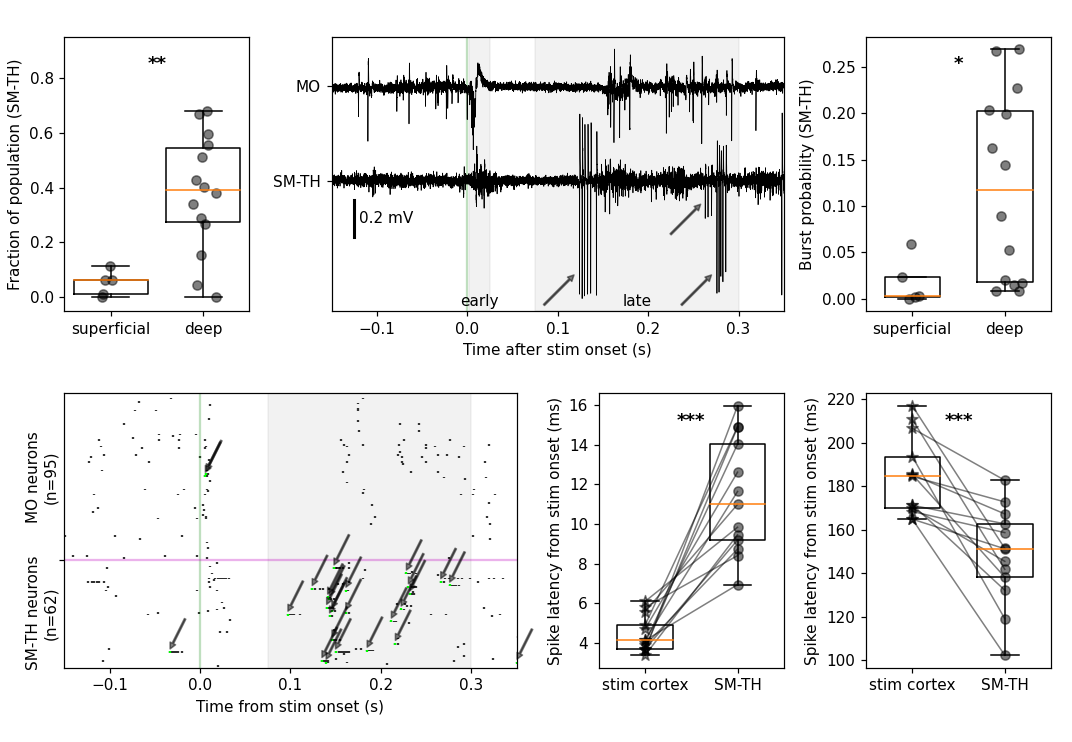

stim_cortex:
region:
 superficial pop fraction: mice=5, mean=0.050, std=0.041, min=0.000, max=0.113
 deep pop fraction: mice=14, mean=0.379, std=0.206, min=0.000, max=0.677
  t-test p-value=0.00374; deep/superfical ratio=7.63x

Burst probability:
 sup: mice=5, median=0.00, IQR=0.00-0.02
 deep: mice=14, median=0.12, IQR=0.02-0.20
  MWU p-value=0.02580; deep/superfical ratio=6.85x

Early latency:
 stim cortex: mice=13, mean=4.42 ms, std=0.87 ms
 SM-TH: mice=13, mean=11.36 ms, std=2.79 ms
  paired t-test p-value=4.8375E-06; mean diff=6.93 ms

Late latency:
 stim cortex: mice=13, mean=184.19 ms, std=17.32 ms
 SM-TH: mice=13, mean=148.18 ms, std=21.22 ms
  paired t-test p-value=2.1362E-04; mean diff=-36.01 ms


In [23]:
plot_stim = 'medium'
plot_state = 'awake'
compare = {'superficial': '^', 'deep': 'o'}
plot_regions = {'stim_cortex': True, 'region': 'MO-TH'}
raster_trial = 2
plot_win = [-0.15, 0.35]
sep = 500
locs1 = np.arange((len(plot_regions) + 1) * len(compare)).reshape((len(compare), (len(plot_regions) + 1)))

fig = plt.figure(figsize=(9.75, 6.75))
gs = fig.add_gridspec(ncols=12, nrows=2, left=0.06, right=0.98, top=0.95, bottom=0.1, wspace=12, hspace=0.3)
axFRS = fig.add_subplot(gs[0,0:3])
axSDF = fig.add_subplot(gs[0,3:9])
axPR = fig.add_subplot(gs[0,9:])
axRASTER = fig.add_subplot(gs[1,0:6])
axEARLY = fig.add_subplot(gs[1,6:9])
axLATE = fig.add_subplot(gs[1,9:])

early_lats = []
late_lats = []
for jj, (categ, spec) in enumerate(plot_regions.items()):
    print('{}:'.format(categ))
    popfracts = []
    burstPR = []
    for ii, (compi, depm) in enumerate(compare.items()):
        df = all_subs_stats_df[
            (all_subs_stats_df['stim_level'] == plot_stim) & (all_subs_stats_df['state'] == plot_state) &
            (all_subs_stats_df['stim_depth'] == compi) & (all_subs_stats_df[categ] == spec)
        ]
        if spec == 'MO-TH':
            ## Plot fraction of population with significant response ##
            fractions = df['fraction_sig'].values
            axFRS.boxplot(fractions, positions=[ii], widths=[0.8], showfliers=False)
            xs = np.random.normal(ii, 0.08, len(fractions))
            axFRS.scatter(xs, fractions, color='k', marker='o', alpha=0.5)
            popfracts.append(fractions)
            print(' {} pop fraction: mice={:d}, mean={:.3f}, std={:.3f}, min={:.3f}, max={:.3f}'.format(
                compi, len(fractions), np.mean(fractions), np.std(fractions), np.min(fractions), np.max(fractions)))

            ## Plot burst probability ##
            probs = df['burst_prob'].values
            axPR.boxplot(probs, positions=[ii], widths=[0.6], showfliers=False)
            xs = np.random.normal(ii, 0.08, len(probs))
            axPR.scatter(xs, probs, color='k', marker='o', alpha=0.5)
            burstPR.append(probs)
            
        if compi == 'deep':
            early_lats.append(df['early_latency'][df['ctx_and_th'] == True].values * 1E3)
            late_lats.append(df['late_latency'][df['ctx_and_th'] == True].values * 1E3)
    
## Make a legend ##
# mhandles = [
#     Line2D([0], [0], marker='^', color='w', markerfacecolor='k', markeredgecolor='k', markersize=7, alpha=0.5),
#     Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markeredgecolor='k', markersize=7, alpha=0.5)
# ]
# axFRS.legend(handles=mhandles, labels=compare.keys(), loc='upper left')
axFRS.set_ylabel('Fraction of population (SM-TH)')
axFRS.set_xticks(np.arange(len(compare)))
axFRS.set_xticklabels(compare.keys())
axFRS.set_ylim([-0.05, 0.95])
## Stats ##
tt_popfract = stats.ttest_ind(popfracts[0], popfracts[1])
print('  t-test p-value={:.5f}; deep/superfical ratio={:.2f}x'.format(
    tt_popfract[1], (np.mean(popfracts[1])/np.mean(popfracts[0]))))
axFRS.annotate(
    p_stars(tt_popfract[1]), xy=(0.5, 0.9), xycoords='axes fraction', ha='center', va='center', fontsize=12, fontweight='bold')

axPR.set_ylabel('Burst probability (SM-TH)')
axPR.set_xticks(np.arange(len(compare)))
axPR.set_xticklabels(compare.keys())
print('\nBurst probability:')
supq25, supq75 = np.percentile(burstPR[0], [25, 75])
dpq25, dpq75 = np.percentile(burstPR[1], [25, 75])
print(' sup: mice={:d}, median={:.2f}, IQR={:.2f}-{:.2f}'.format(len(burstPR[0]), np.median(burstPR[0]), supq25, supq75))
print(' deep: mice={:d}, median={:.2f}, IQR={:.2f}-{:.2f}'.format(len(burstPR[1]), np.mean(burstPR[1]), dpq25, dpq75))
tt_burstPR = stats.mannwhitneyu(burstPR[0], burstPR[1])
print('  MWU p-value={:.5f}; deep/superfical ratio={:.2f}x'.format(tt_burstPR[1], (np.mean(burstPR[1])/np.mean(burstPR[0]))))
axPR.annotate(
    p_stars(tt_burstPR[1]), xy=(0.5, 0.9), xycoords='axes fraction', ha='center', va='center', fontsize=12, fontweight='bold')

## Plot raster plot ##
axRASTER.axvline(0, color='g', alpha=0.25)
ui = 0
regb = [ui]
for regi in ['MO-TH', 'MO']:
    ulist = example_unit_info['MOs_deep'][regi].sort_values(by='depth', ascending=False)['unit_id'].values
    for uid in ulist:
        axRASTER.eventplot(
            [example_unit_spikes['MOs_deep'][plot_stim][plot_state][uid]['spikes'][raster_trial]],
            lineoffsets=ui, linelengths=1.0, color='black', alpha=0.8
        )
        axRASTER.eventplot(
            [example_unit_spikes['MOs_deep'][plot_stim][plot_state][uid]['bursts'][raster_trial]],
            lineoffsets=ui, linelengths=1.2, color='lime'
        )
        for bburst in example_unit_spikes['MOs_deep'][plot_stim][plot_state][uid]['bursts'][raster_trial]:
            axRASTER.annotate(
                '', xy=(bburst,ui+2), xycoords='data', xytext=(15,30), textcoords='offset pixels',
                arrowprops=dict(fc='k', width=1, headwidth=4, headlength=4, alpha=0.5)
            )
        ui += 1
    regb.append(ui)
    ui += 1
axRASTER.set_xlim(plot_win)
axRASTER.set_xlabel('Time from stim onset (s)')
axRASTER.set_ylim(-1, ui)
axRASTER.axhline(regb[1], color='m', alpha=0.3)
axRASTER.set_yticks([regb[1]])
axRASTER.set_yticklabels([])
axRASTER.annotate(
    'SM-TH neurons\n(n={:d})'.format(regb[1]), xy=(-0.175, np.mean(regb[:2])), xycoords='data', annotation_clip=False,
    rotation=90, ha='center', va='center', fontsize=10
)
axRASTER.annotate(
    'MO neurons\n(n={:d})'.format(regb[2]-regb[1]-1), xy=(-0.175, np.mean(regb[1:])), xycoords='data', annotation_clip=False,
    rotation=90, ha='center', va='center', fontsize=10
)
axRASTER.axvspan(0.075, 0.3, color='k', alpha=0.05)
        
## Plot raw traces ##
axSDF.axvline(0, color='g', alpha=0.25, label='_nolegend_')
tick_locs = []
for ii, (pb, pbinfo) in enumerate(plot_probes.items()):
    chmask = example_info[pb]['ch_list'] == pbinfo[1]
    axSDF.plot(example_info[pb]['data'][0], example_info[pb]['data'][1][:, chmask] + (sep*ii), 'k', linewidth=0.5)
    tick_locs.append(sep*ii)
axSDF.set_xlim(plot_win)
axSDF.set_xlabel('Time after stim onset (s)')
axSDF.set_yticks(tick_locs)
axSDF.set_yticklabels(['SM-TH', 'MO'])
axSDF.axvspan(0.075, 0.3, color='k', alpha=0.05)
axSDF.axvspan(0.002, 0.025, color='k', alpha=0.05)
axSDF.annotate('late', xy=(np.mean([0.075, 0.3]), -680), xycoords='data', ha='center', va='bottom', fontsize=10)
axSDF.annotate('early', xy=(np.mean([0.002, 0.025]), -680), xycoords='data', ha='center', va='bottom', fontsize=10)
axSDF.annotate(
    '', xy=(0.118, -sep), xycoords='data', xytext=(-30,-30), textcoords='offset pixels',
    arrowprops=dict(fc='k', width=1, headwidth=4, headlength=4, alpha=0.5)
)
axSDF.annotate(
    '', xy=(0.27, -sep), xycoords='data', xytext=(-30,-30), textcoords='offset pixels',
    arrowprops=dict(fc='k', width=1, headwidth=4, headlength=4, alpha=0.5)
)
axSDF.annotate(
    '', xy=(0.258, -125), xycoords='data', xytext=(-30,-30), textcoords='offset pixels',
    arrowprops=dict(fc='k', width=1, headwidth=4, headlength=4, alpha=0.5)
)
axSDF.plot([-0.125, -0.125], [-100, -300], color='k', linewidth=2)
axSDF.annotate('0.2 mV', xy=(-0.12, -200), xycoords='data', va='center', ha='left', fontsize=10)

## Plot latencies, early and late ##
axEARLY.boxplot(np.stack(early_lats).T, positions=[0, 1], widths=[0.6, 0.6], showfliers=False)
# axEARLY.plot([0,1], np.stack(early_lats), 'k', marker='o', markersize=8, alpha=0.5)
axEARLY.plot([0,1], np.stack(early_lats), 'k', linewidth=1.0, alpha=0.5)
axEARLY.scatter(np.zeros_like(early_lats[0]), early_lats[0], color='k', marker='*', s=60, alpha=0.5)
axEARLY.scatter(np.ones_like(early_lats[1]), early_lats[1], color='k', alpha=0.5)
axEARLY.set_xticklabels(['stim cortex', 'SM-TH'])
axEARLY.set_ylabel('Spike latency from stim onset (ms)')
print('\nEarly latency:')
print(' stim cortex: mice={:d}, mean={:.2f} ms, std={:.2f} ms'.format(
    len(early_lats[0]), np.mean(early_lats[0]), np.std(early_lats[0])))
print(' SM-TH: mice={:d}, mean={:.2f} ms, std={:.2f} ms'.format(
    len(early_lats[1]), np.mean(early_lats[1]), np.std(early_lats[1])))
early_ptt = stats.ttest_rel(early_lats[0], early_lats[1])
print('  paired t-test p-value={:.4E}; mean diff={:.2f} ms'.format(
    early_ptt[1], np.mean(early_lats[1] - early_lats[0])))
axEARLY.annotate(
    p_stars(early_ptt[1]), xy=(0.5, 0.9), xycoords='axes fraction', ha='center', va='center', fontweight='bold', fontsize=12
)

axLATE.boxplot(np.stack(late_lats).T, positions=[0, 1], widths=[0.6, 0.6], showfliers=False)
axLATE.plot([0,1], np.stack(late_lats), 'k', linewidth=1.0, alpha=0.5)
axLATE.scatter(np.zeros_like(late_lats[0]), late_lats[0], color='k', marker='*', s=60, alpha=0.5)
axLATE.scatter(np.ones_like(late_lats[1]), late_lats[1], color='k', alpha=0.5)
axLATE.set_xticklabels(['stim cortex', 'SM-TH'])
axLATE.set_ylabel('Spike latency from stim onset (ms)')
print('\nLate latency:')
print(' stim cortex: mice={:d}, mean={:.2f} ms, std={:.2f} ms'.format(
    len(late_lats[0]), np.mean(late_lats[0]), np.std(late_lats[0])))
print(' SM-TH: mice={:d}, mean={:.2f} ms, std={:.2f} ms'.format(
    len(late_lats[1]), np.mean(late_lats[1]), np.std(late_lats[1])))
late_ptt = stats.ttest_rel(late_lats[0], late_lats[1])
print('  paired t-test p-value={:.4E}; mean diff={:.2f} ms'.format(
    late_ptt[1], np.mean(late_lats[1] - late_lats[0])))
axLATE.annotate(
    p_stars(late_ptt[1]), xy=(0.5, 0.9), xycoords='axes fraction', ha='center', va='center', fontweight='bold', fontsize=12
)

## Save ##
figname = 'Fig5_v7_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

## Save as .pdf for Illustrator ##
# fig.savefig(os.path.join(plotsdir, 'AI_pdfs', figname.replace('.png', '.pdf')), transparent=True, dpi=300)

#### Plot individual probes

### Original Fig 5 with population SDF for panel D

<IPython.core.display.Javascript object>


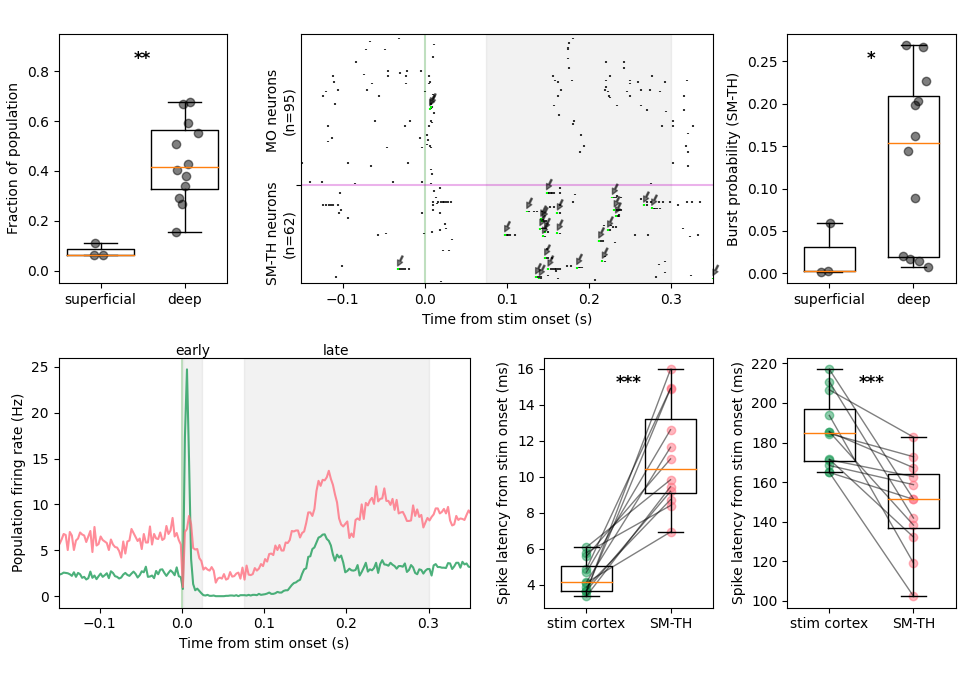

stim_cortex:
region:
 superficial pop fraction: mice=3, mean=0.079, std=0.024, min=0.062, max=0.113
 deep pop fraction: mice=12, mean=0.439, std=0.157, min=0.155, max=0.677
  t-test p-value=0.00281; deep/superfical ratio=5.55x

Burst probability:
 sup: mice=3, median=0.00, IQR=0.00-0.03
 deep: mice=12, median=0.14, IQR=0.02-0.21
  MWU p-value=0.04835; deep/superfical ratio=6.33x

Early latency:
 stim cortex: mice=12, mean=4.46 ms, std=0.89 ms
 SM-TH: mice=12, mean=11.14 ms, std=2.79 ms
  paired t-test p-value=1.70E-05; mean diff=6.68 ms

Late latency:
 stim cortex: mice=12, mean=185.37 ms, std=17.52 ms
 SM-TH: mice=12, mean=148.41 ms, std=22.08 ms
  paired t-test p-value=0.00042; mean diff=-36.96 ms


In [32]:
plot_stim = 'medium'
plot_state = 'awake'
compare = {'superficial': '^', 'deep': 'o'}
plot_regions = {'stim_cortex': True, 'region': 'MO-TH'}
raster_trial = 2
plot_win = [-0.15, 0.35]
locs1 = np.arange((len(plot_regions) + 1) * len(compare)).reshape((len(compare), (len(plot_regions) + 1)))

fig = plt.figure(figsize=(9.75, 6.75))
gs = fig.add_gridspec(ncols=12, nrows=2, left=0.06, right=0.98, top=0.95, bottom=0.1, wspace=12, hspace=0.3)
axFRS = fig.add_subplot(gs[0,0:3])
axRASTER = fig.add_subplot(gs[0,3:9])
axPR = fig.add_subplot(gs[0,9:])
axSDF = fig.add_subplot(gs[1,0:6])
axEARLY = fig.add_subplot(gs[1,6:9])
axLATE = fig.add_subplot(gs[1,9:])

early_lats = []
late_lats = []
for jj, (categ, spec) in enumerate(plot_regions.items()):
    print('{}:'.format(categ))
    popfracts = []
    burstPR = []
    for ii, (compi, depm) in enumerate(compare.items()):
        df = all_subs_stats_df[
            (all_subs_stats_df['stim_level'] == plot_stim) & (all_subs_stats_df['state'] == plot_state) &
            (all_subs_stats_df['stim_depth'] == compi) & (all_subs_stats_df[categ] == spec)
        ]
        if spec == 'MO-TH':
            ## Plot fraction of population with significant response ##
            fractions = df['fraction_sig'].values
            axFRS.boxplot(fractions, positions=[ii], widths=[0.8], showfliers=False)
            xs = np.random.normal(ii, 0.08, len(fractions))
            axFRS.scatter(xs, fractions, color='k', marker='o', alpha=0.5)
            popfracts.append(fractions)
            print(' {} pop fraction: mice={:d}, mean={:.3f}, std={:.3f}, min={:.3f}, max={:.3f}'.format(
                compi, len(fractions), np.mean(fractions), np.std(fractions), np.min(fractions), np.max(fractions)))

            ## Plot burst probability ##
            probs = df['burst_prob'].values
            axPR.boxplot(probs, positions=[ii], widths=[0.6], showfliers=False)
            xs = np.random.normal(ii, 0.08, len(probs))
            axPR.scatter(xs, probs, color='k', marker='o', alpha=0.5)
            burstPR.append(probs)
            
        if compi == 'deep':
            early_lats.append(df['early_latency'][df['ctx_and_th'] == True].values * 1E3)
            late_lats.append(df['late_latency'][df['ctx_and_th'] == True].values * 1E3)
    
## Make a legend ##
# mhandles = [
#     Line2D([0], [0], marker='^', color='w', markerfacecolor='k', markeredgecolor='k', markersize=7, alpha=0.5),
#     Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markeredgecolor='k', markersize=7, alpha=0.5)
# ]
# axFRS.legend(handles=mhandles, labels=compare.keys(), loc='upper left')
axFRS.set_ylabel('Fraction of population')
axFRS.set_xticks(np.arange(len(compare)))
axFRS.set_xticklabels(compare.keys())
axFRS.set_ylim([-0.05, 0.95])
## Stats ##
tt_popfract = stats.ttest_ind(popfracts[0], popfracts[1])
print('  t-test p-value={:.5f}; deep/superfical ratio={:.2f}x'.format(
    tt_popfract[1], (np.mean(popfracts[1])/np.mean(popfracts[0]))))
axFRS.annotate(
    p_stars(tt_popfract[1]), xy=(0.5, 0.9), xycoords='axes fraction', ha='center', va='center', fontsize=12, fontweight='bold')

axPR.set_ylabel('Burst probability (SM-TH)')
axPR.set_xticks(np.arange(len(compare)))
axPR.set_xticklabels(compare.keys())
print('\nBurst probability:')
supq25, supq75 = np.percentile(burstPR[0], [25, 75])
dpq25, dpq75 = np.percentile(burstPR[1], [25, 75])
print(' sup: mice={:d}, median={:.2f}, IQR={:.2f}-{:.2f}'.format(len(burstPR[0]), np.median(burstPR[0]), supq25, supq75))
print(' deep: mice={:d}, median={:.2f}, IQR={:.2f}-{:.2f}'.format(len(burstPR[1]), np.mean(burstPR[1]), dpq25, dpq75))
tt_burstPR = stats.mannwhitneyu(burstPR[0], burstPR[1])
print('  MWU p-value={:.5f}; deep/superfical ratio={:.2f}x'.format(tt_burstPR[1], (np.mean(burstPR[1])/np.mean(burstPR[0]))))
axPR.annotate(
    p_stars(tt_burstPR[1]), xy=(0.5, 0.9), xycoords='axes fraction', ha='center', va='center', fontsize=12, fontweight='bold')

## Plot raster plot ##
axRASTER.axvline(0, color='g', alpha=0.25)
ui = 0
regb = [ui]
for regi in ['MO-TH', 'MO']:
    ulist = example_unit_info['MOs_deep'][regi].sort_values(by='depth', ascending=False)['unit_id'].values
    for uid in ulist:
        axRASTER.eventplot(
            [example_unit_spikes['MOs_deep'][plot_stim][plot_state][uid]['spikes'][raster_trial]],
            lineoffsets=ui, linelengths=1.0, color='black', alpha=0.8
        )
        axRASTER.eventplot(
            [example_unit_spikes['MOs_deep'][plot_stim][plot_state][uid]['bursts'][raster_trial]],
            lineoffsets=ui, linelengths=1.2, color='lime'
        )
        for bburst in example_unit_spikes['MOs_deep'][plot_stim][plot_state][uid]['bursts'][raster_trial]:
            axRASTER.annotate(
                '', xy=(bburst,ui+2), xycoords='data', xytext=(5,10), textcoords='offset pixels',
                arrowprops=dict(fc='k', width=1, headwidth=4, headlength=4, alpha=0.5)
            )
        ui += 1
    regb.append(ui)
    ui += 1
axRASTER.set_xlim(plot_win)
axRASTER.set_xlabel('Time from stim onset (s)')
axRASTER.set_ylim(-1, ui)
axRASTER.axhline(regb[1], color='m', alpha=0.3)
axRASTER.set_yticks([regb[1]])
axRASTER.set_yticklabels([])
axRASTER.annotate(
    'SM-TH neurons\n(n={:d})'.format(regb[1]), xy=(-0.175, np.mean(regb[:2])), xycoords='data', annotation_clip=False,
    rotation=90, ha='center', va='center', fontsize=10
)
axRASTER.annotate(
    'MO neurons\n(n={:d})'.format(regb[2]-regb[1]-1), xy=(-0.175, np.mean(regb[1:])), xycoords='data', annotation_clip=False,
    rotation=90, ha='center', va='center', fontsize=10
)
axRASTER.axvspan(0.075, 0.3, color='k', alpha=0.05)
        
## Plot population SDF ##
axSDF.axvline(0, color='g', alpha=0.25, label='_nolegend_')
for regi, datai in example_pop_sdf['MOs_deep'][plot_stim][plot_state].items():
    axSDF.plot(datai[0], datai[1], color=area_colors[regi], linewidth=1.5, alpha=0.8, label=regi)
axSDF.set_ylabel('Population firing rate (Hz)')
axSDF.set_xlabel('Time from stim onset (s)')
axSDF.set_xlim(plot_win)
axSDF.axvspan(0.075, 0.3, color='k', alpha=0.05)
axSDF.axvspan(0.002, 0.025, color='k', alpha=0.05)
axSDF.annotate(
    'late', xy=(np.mean([0.075, 0.3]), 26), xycoords='data', annotation_clip=False, ha='center', va='bottom', fontsize=10
)
axSDF.annotate(
    'early', xy=(np.mean([0.002, 0.025]), 26), xycoords='data', annotation_clip=False, ha='center', va='bottom', fontsize=10
)
axSDF.legend(labels=['MO', 'SM-TH'])

## Plot latencies, early and late ##
axEARLY.boxplot(np.stack(early_lats).T, positions=[0, 1], widths=[0.6, 0.6], showfliers=False)
# axEARLY.plot([0,1], np.stack(early_lats), 'k', marker='o', markersize=8, alpha=0.5)
axEARLY.plot([0,1], np.stack(early_lats), 'k', linewidth=1.0, alpha=0.5)
axEARLY.scatter(np.zeros_like(early_lats[0]), early_lats[0], color=area_colors['MO'], alpha=0.5)
axEARLY.scatter(np.ones_like(early_lats[1]), early_lats[1], color=area_colors['MO-TH'], alpha=0.5)
axEARLY.set_xticklabels(['stim cortex', 'SM-TH'])
axEARLY.set_ylabel('Spike latency from stim onset (ms)')
print('\nEarly latency:')
print(' stim cortex: mice={:d}, mean={:.2f} ms, std={:.2f} ms'.format(
    len(early_lats[0]), np.mean(early_lats[0]), np.std(early_lats[0])))
print(' SM-TH: mice={:d}, mean={:.2f} ms, std={:.2f} ms'.format(
    len(early_lats[1]), np.mean(early_lats[1]), np.std(early_lats[1])))
early_ptt = stats.ttest_rel(early_lats[0], early_lats[1])
print('  paired t-test p-value={:.2E}; mean diff={:.2f} ms'.format(
    early_ptt[1], np.mean(early_lats[1] - early_lats[0])))
axEARLY.annotate(
    p_stars(early_ptt[1]), xy=(0.5, 0.9), xycoords='axes fraction', ha='center', va='center', fontweight='bold', fontsize=12
)

axLATE.boxplot(np.stack(late_lats).T, positions=[0, 1], widths=[0.6, 0.6], showfliers=False)
axLATE.plot([0,1], np.stack(late_lats), 'k', linewidth=1.0, alpha=0.5)
axLATE.scatter(np.zeros_like(late_lats[0]), late_lats[0], color=area_colors['MO'], alpha=0.5)
axLATE.scatter(np.ones_like(late_lats[1]), late_lats[1], color=area_colors['MO-TH'], alpha=0.5)
axLATE.set_xticklabels(['stim cortex', 'SM-TH'])
axLATE.set_ylabel('Spike latency from stim onset (ms)')
print('\nLate latency:')
print(' stim cortex: mice={:d}, mean={:.2f} ms, std={:.2f} ms'.format(
    len(late_lats[0]), np.mean(late_lats[0]), np.std(late_lats[0])))
print(' SM-TH: mice={:d}, mean={:.2f} ms, std={:.2f} ms'.format(
    len(late_lats[1]), np.mean(late_lats[1]), np.std(late_lats[1])))
late_ptt = stats.ttest_rel(late_lats[0], late_lats[1])
print('  paired t-test p-value={:.5f}; mean diff={:.2f} ms'.format(
    late_ptt[1], np.mean(late_lats[1] - late_lats[0])))
axLATE.annotate(
    p_stars(late_ptt[1]), xy=(0.5, 0.9), xycoords='axes fraction', ha='center', va='center', fontweight='bold', fontsize=12
)

## Save ##
figname = 'Fig5_v6_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

In [25]:
burstPR

[array([0.05923754, 0.00292096, 0.00182292]),
 array([0.01472222, 0.02002033, 0.26659722, 0.26913978, 0.20336879,
        0.22734094, 0.16252252, 0.19901586, 0.08898165, 0.14426714,
        0.01718213, 0.0078125 ])]

#### Normality tests

early, stim cortex: 3/4 NORMAL

early, MO-TH: 3/4 NORMAL

late, stim cortex: 3/4 NORMAL

late, MO-TH: 3/4 NORMAL

In [43]:
test_values = late_lats[1]

## D'Agostinos K-squared test ##
Dk2, Dpnorm = stats.normaltest(test_values)
if Dpnorm < sigalpha:
    print('DAgostinos K-squared test: NOT normal')
else:
    print('DAgostinos K-squared test: normal')

## Anderson-Darling test ##
stt, critv, ADpnorm = stats.anderson(test_values, dist='norm')
if stt > critv[4]:
    print('Anderson-Darling test: NOT normal')
else:
    print('Anderson-Darling test: normal')
    
## Kolmogorov-Smirnov test ##
ksstat, ksp = stats.kstest(test_values, 'norm')
if ksp < sigalpha:
    print('Kolmogorov-Smirnov test: NOT normal')
else:
    print('Kolmogorov-Smirnov test: normal')
    
## Shapiro-Wilk test ##
swstat, swp = stats.shapiro(test_values)
if swp < sigalpha:
    print('Shapiro-Wilk test: NOT normal')
else:
    print('Shapiro-Wilk test: normal')

DAgostinos K-squared test: normal
Anderson-Darling test: normal
Kolmogorov-Smirnov test: NOT normal
Shapiro-Wilk test: normal


Original plot

### Make a plot comparing fraction responsive for stim ctx and MO-TH in superficial vs. deep stim 

<IPython.core.display.Javascript object>


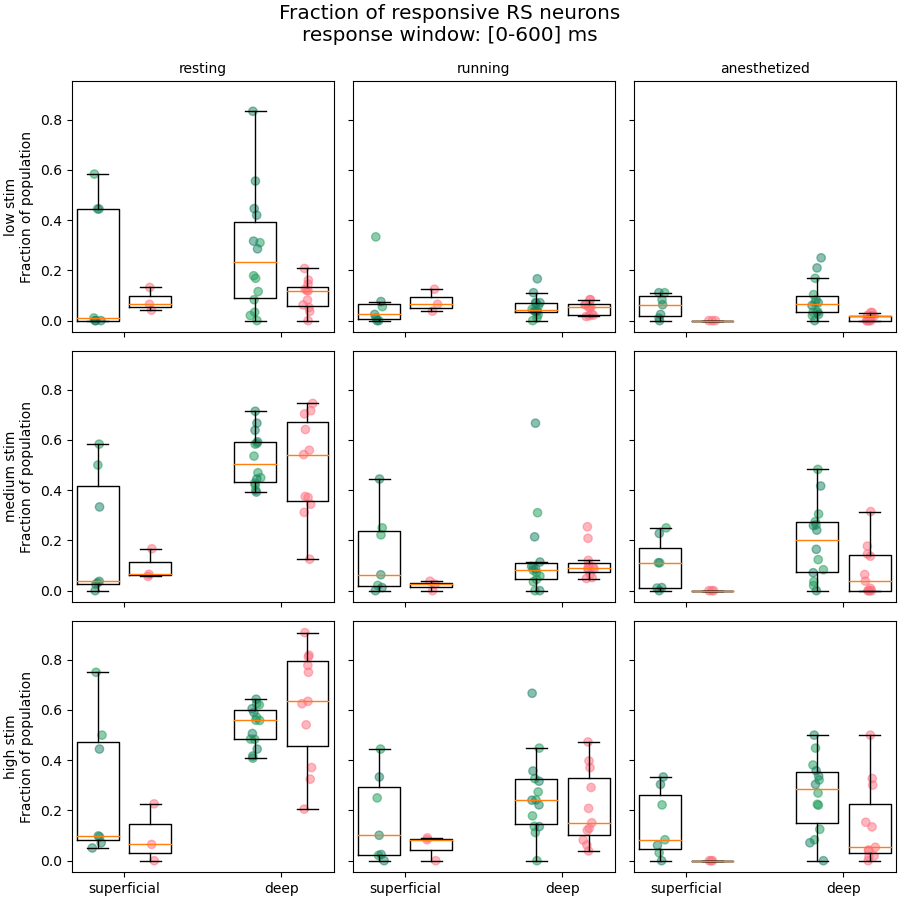

In [27]:
compare = ['superficial', 'deep']
plot_regions = {'stim_cortex': True, 'region': 'MO-TH'}
barlocs = np.arange((len(plot_regions) + 1) * len(compare)).reshape((len(compare), (len(plot_regions) + 1)))

fig, axs = plt.subplots(
    len(current_levels), len(state_colors), figsize=(9, 9), sharex=True, sharey=True, constrained_layout=True)

for rowi, leveli in enumerate(current_levels):
    for coli, (statei, scolori) in enumerate(state_colors.items()):
        for ii, compi in enumerate(compare):
            for jj, (categ, spec) in enumerate(plot_regions.items()):
                df = all_subs_stats_df[
                    (all_subs_stats_df['stim_level'] == leveli) & (all_subs_stats_df['state'] == statei) &
                    (all_subs_stats_df['stim_depth'] == compi) & (all_subs_stats_df[categ] == spec)
                ]
                fractions = df['fr_resp'].values
                sccolors = [area_colors[regi] for regi in df['region'].values]
                axs[rowi, coli].boxplot(fractions, positions=[barlocs[ii, jj]], widths=[0.8], showfliers=False)
                xs = np.random.normal(barlocs[ii, jj], 0.05, len(fractions))
                axs[rowi, coli].scatter(xs, fractions, c=sccolors, alpha=0.5)
                
#                 axs[rowi, coli].bar(barlocs[ii, jj], fraction, color=[area_colors[regi]])
        if rowi == 0:
            axs[rowi, coli].set_title(statei)
        if coli == 0:
            axs[rowi, coli].set_ylabel('{} stim\nFraction of population'.format(leveli))
axs[2,1].set_xticks(np.mean(barlocs[:,:-1], axis=1))
axs[2,1].set_xticklabels(compare)

## Make a legend ##
# mhandles = []
# for regi in plot_regions:
#     mhandles.append(Patch(color=area_colors[regi], label=regi))
# axs[0,0].legend(handles=mhandles)

plt.suptitle('Fraction of responsive {} neurons\nresponse window: [{:d}-{:d}] ms'.format(
    celltype, int(test_window[0]*1E3), int(test_window[1]*1E3)))

## Save ##
figname = 'FractionResponsive_all_supvsdeep_{:d}-{:d}ms.png'.format(int(test_window[0]*1E3), int(test_window[1]*1E3))
fig.savefig(os.path.join(plotsdir, figname), transparent=False)

<IPython.core.display.Javascript object>


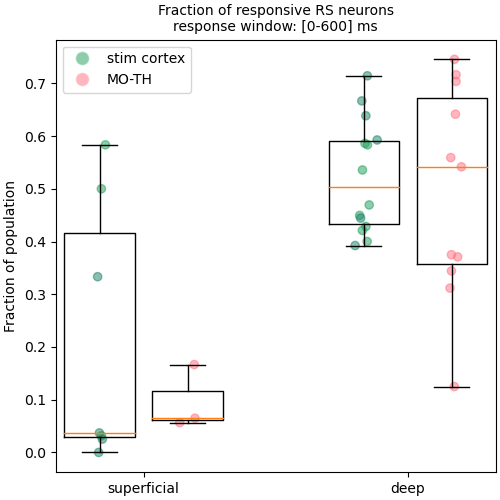

In [43]:
compare = ['superficial', 'deep']
plot_regions = {'stim_cortex': True, 'region': 'MO-TH'}
barlocs = np.arange((len(plot_regions) + 1) * len(compare)).reshape((len(compare), (len(plot_regions) + 1)))

pstim = 'medium'
pstate = 'resting'

fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)

for ii, compi in enumerate(compare):
    for jj, (categ, spec) in enumerate(plot_regions.items()):
        df = all_subs_stats_df[
            (all_subs_stats_df['stim_level'] == pstim) & (all_subs_stats_df['state'] == pstate) &
            (all_subs_stats_df['stim_depth'] == compi) & (all_subs_stats_df[categ] == spec)
        ]
        fractions = df['fr_resp'].values
        sccolors = [area_colors[regi] for regi in df['region'].values]
        ax.boxplot(fractions, positions=[barlocs[ii, jj]], widths=[0.8], showfliers=False)
        xs = np.random.normal(barlocs[ii, jj], 0.05, len(fractions))
        ax.scatter(xs, fractions, c=sccolors, alpha=0.5)
ax.set_ylabel('Fraction of population')
ax.set_xticks(np.mean(barlocs[:,:-1], axis=1))
ax.set_xticklabels(compare)

## Make a legend ##
mhandles = [
    Line2D([0], [0], marker='o', color='w', label='stim cortex', markerfacecolor=area_colors['MO'], markersize=10, alpha=0.5),
    Line2D([0], [0], marker='o', color='w', label='MO-TH', markerfacecolor=area_colors['MO-TH'], markersize=10, alpha=0.5),
]

ax.legend(handles=mhandles)

ax.set_title('Fraction of responsive {} neurons\nresponse window: [{:d}-{:d}] ms'.format(
    celltype, int(test_window[0]*1E3), int(test_window[1]*1E3)))

## Save ##
figname = 'FractionResponsive_all_supvsdeep_{}-{}_{:d}-{:d}ms.png'.format(
    pstim, pstate, int(test_window[0]*1E3), int(test_window[1]*1E3))
fig.savefig(os.path.join(plotsdir, figname), transparent=False)

## Make figure for GRC poster 2022